In [19]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [20]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [21]:
data

,sent_id,text,label
7803,102688-02-01,iranskfødte tooji forsøker godt dansbart orien...,2
9690,200102-19-02,nettbrett mobil pc mac via bluetooth dermed te...,2
4333,004273-10-01,filmen basert roman jonas jonasson byr snedige...,2
6641,202389-03-03,slike spillmatiseringer absolutt dårlig ide fo...,2
3823,500322-07-01,filmen demonstrasjon kathryn bigelows posisjon...,2
...,...,...,...
1486,702788-05-01,hjernen lat,0
2457,304309-05-10,altfor selvgodt sikker voksne kvinner verden,0
7123,003889-08-01,forundrer prosjektet tiltalte fincher,0
4451,201835-11-02,imidlertid spesielt godt sortnivå virker fatti...,0


<AxesSubplot:>

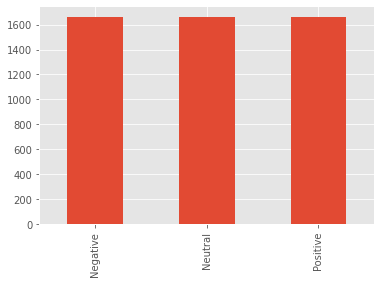

In [22]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

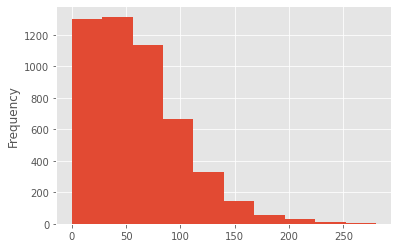

In [23]:
data["text"].str.len().plot.hist()

In [24]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42,
                                                    shuffle=True)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 802 contains 4 words and is Negative
Review content:

filmen strabasiøst blottet humor


In [26]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [27]:
word_counter.most_common(10)

[('litt', 171),
 ('får', 131),
 ('the', 114),
 ('godt', 109),
 ('gjør', 107),
 ('to', 107),
 ('år', 104),
 ('helt', 104),
 ('filmen', 101),
 ('nok', 99)]

In [28]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [29]:
from keras.utils.np_utils import to_categorical
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [30]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (4490, 100)
X_test shape: (499, 100)


In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))

In [32]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [33]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
225/225 [==============================] - 63s 219ms/step - loss: 1.0652 - accuracy: 0.4104 - val_loss: 1.0399 - val_accuracy: 0.4421
Epoch 2/20
225/225 [==============================] - 48s 214ms/step - loss: 0.6999 - accuracy: 0.7339 - val_loss: 1.2573 - val_accuracy: 0.5045
Epoch 3/20
225/225 [==============================] - 49s 216ms/step - loss: 0.2249 - accuracy: 0.9215 - val_loss: 1.4547 - val_accuracy: 0.4855
Epoch 4/20
225/225 [==============================] - 29s 130ms/step - loss: 0.0832 - accuracy: 0.9747 - val_loss: 1.5916 - val_accuracy: 0.4644
Epoch 5/20
225/225 [==============================] - 29s 131ms/step - loss: 0.0364 - accuracy: 0.9897 - val_loss: 1.9177 - val_accuracy: 0.4822


In [34]:
from datetime import datetime

model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

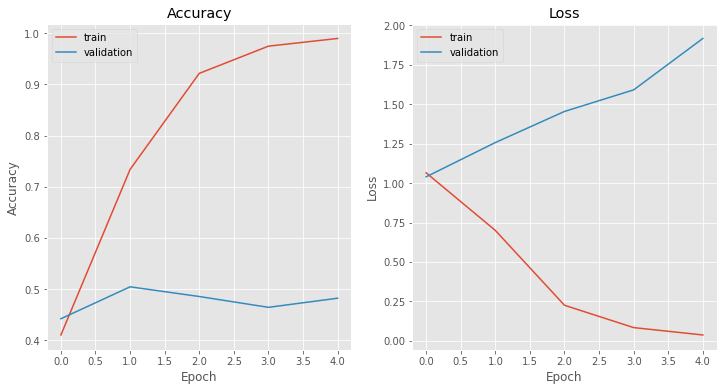

In [35]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [36]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

16/16 [==============================] - 0s 24ms/step - loss: 2.0535 - accuracy: 0.4990
Validation loss: 2.053541660308838
Validation accuracy: 0.4989979863166809
